# **Take-Home Exam 2 (THE-2)**
## CENG403 - Spring 2025

In this THE, we will focus on implementing a CNN and an RNN from scratch or using PyTorch:

*   Task 1: Implementing a forward function of your own deformable CNN from scratch (30 pts).
*   Task 2: Implementing CNN in PyTorch (40 pts).
*   Task 3: Implementing RNN using torch.autograd (30 pts).

**Getting Ready**

You can use the following tutorials if you need more details about the libraries/tools you will use:

*   **Jupyter Notebook and Colab**:
 * https://www.dataquest.io/blog/jupyter-notebook-tutorial/
 * https://colab.research.google.com/
* **NumPy**
 * https://numpy.org/devdocs/user/quickstart.html
* **PyTorch**:
 * https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html


## **Task 1: Implement a Forward Pass of Your Own Deformable CNN (30 Points)**

In this task, you are responsible for implementing the forward pass of [deformable convolution v2](https://arxiv.org/abs/1811.11168).

**Note that you should implement all functions from scratch! Using PyTorch or any other libraries except for `numpy` in your implementation will be evaluated as 0 (zero).**


### **1.1 Forward Pass Implementation (30 Points)**

Standard convolution (along one dimension of the input layer) with a filter size of $K$ at location $\mathbf{p}_0$ can be formally defined as:

$$
\mathbf{a}^{l+1}(\mathbf{p}_0) = \sum_{k=0}^{K-1}  \mathbf{w}(k) \cdot \mathbf{a}^l(\mathbf{p}_0 + \mathbf{p}_k),
$$

where:

*    $\mathbf{a}^l$ is the input feature map,
*    $\mathbf{a}^{l+1}$ is the output feature map,
*    $\mathbf{w}$ is the convolution kernel,
*    $\mathbf{p}_k$ is the fixed offset of the $k$-th sampling location (e.g., for a 1D feature map and a filter size of 3, $\mathbf{p}_k \in \{0, 1, 2\}$).


Deformable convolution v2 introduces learnable offsets $\Delta \mathbf{p}_k$ and modulation scalars $m_k \in [0,1]$:

$$
\mathbf{a}^{l+1}(\mathbf{p}_0) = \sum_{k=0}^{K-1} \mathbf{w}(k) \cdot \left( m_k \cdot \mathbf{a}^l(\mathbf{p}_0 + \mathbf{p}_k + \Delta \mathbf{p}_k) \right),
$$

where:

*    $\Delta \mathbf{p}_k$ are learned dynamic offsets,
*    $m_k$ are learned modulation scalars (also called a mask).

Since $\mathbf{p}_0 + \mathbf{p}_k + \Delta \mathbf{p}_k$ may be fractional, bilinear interpolation is used. For any fractional position $\mathbf{q}$ with $x$ and $y$ coordinates  $\mathbf{q} = (q_x, q_y)$, we first identify the closest integer positions:

$$
\begin{aligned}
\mathbf{p}_{\text{lt}} &= (\lfloor q_x \rfloor, \lfloor q_y \rfloor) \quad \text{(left top)}, \\
\mathbf{p}_{\text{rt}} &= (\lceil q_x \rceil, \lfloor q_y \rfloor) \quad \text{(right top)}, \\
\mathbf{p}_{\text{lb}} &= (\lfloor q_x \rfloor, \lceil q_y \rceil) \quad \text{(left bottom)}, \\
\mathbf{p}_{\text{rb}} &= (\lceil q_x \rceil, \lceil q_y \rceil) \quad \text{(right bottom)},
\end{aligned}
$$

where $\lfloor \cdot \rfloor$ denotes rounding down, and $\lceil \cdot \rceil$ rounding up to the closest integer.

Given these closest integer positions, bilinear interpolation for a fractional position $\mathbf{q}$ can be defined as:

$$
\mathbf{a}(\mathbf{q}) = \sum_{\mathbf{p}_i \in \{\mathbf{p}_{\text{lt}}, \mathbf{p}_{\text{rt}}, \mathbf{p}_{\text{lb}}, \mathbf{p}_{\text{rb}}\}} G(\mathbf{p}_i, \mathbf{q}) \cdot \mathbf{a}(\mathbf{p}_i),
$$

where the bilinear interpolation weight $G(\mathbf{p}, \mathbf{q})$ is:

$$
G(\mathbf{p}, \mathbf{q}) = (1 - |{p}_x - {q}_{x}|) \cdot (1 - |{p}_y - {q}_{y}|).
$$

With these definitions, we can write down deformable convolution in a complete form as follows:

$$
\mathbf{a}^{l+1}(\mathbf{p}_0) = \sum_{k=0}^{K-1} \mathbf{w}(k) \cdot m_k \cdot \left( \sum_{\mathbf{p}_i} G(\mathbf{p}_i, \mathbf{p}_0 + \mathbf{p}_k + \Delta \mathbf{p}_k) \cdot \mathbf{a}^l(\mathbf{p}_i) \right).
$$

For more details, please check the [paper](https://arxiv.org/abs/1811.11168) or [this tutorial](https://pub.towardsai.net/review-dcnv2-deformable-convnets-v2-object-detection-instance-segmentation-3d8a18bee2f5).

You are expected to complete the given `deformable_conv2d_np()` function.

**Do not change functions arguments and return value.**

In [187]:
import numpy as np

def bilinear_interpolate(a_l, q_y, q_x):
    """
    Perform bilinear interpolation on the input activation map at the given (fractional) coordinates.

    Args:
        a_l (np.ndarray): 2D array of shape (H, W) representing the activation map (feature map) at a certain layer.
        q_y (float): Y-coordinate (row index) where interpolation is to be performed.
        q_x (float): X-coordinate (column index) where interpolation is to be performed.

    Returns:
        out (np.ndarray): Interpolated value at (q_x, q_y).
    """
    #####################################################
    # Implement bilinear interpolation
    #####################################################
    H, W = a_l.shape

    if q_y < 0 or q_y >= H or q_x < 0 or q_x >= W:
        return 0.0

    # Get the coordinates of the 4 surrounding pixels
    y0 = int(np.floor(q_y))
    x0 = int(np.floor(q_x))
    y1 = y0 + 1
    x1 = x0 + 1

    # Initialize values (default to 0 for out-of-bounds)
    def isValid(y, x, H, W): return 0 <= y < H and 0 <= x < W
    v00 = a_l[y0, x0] if isValid(y0, x0, H, W) else 0.0
    v01 = a_l[y0, x1] if isValid(y0, x1, H, W) else 0.0
    v10 = a_l[y1, x0] if isValid(y1, x0, H, W) else 0.0
    v11 = a_l[y1, x1] if isValid(y1, x1, H, W) else 0.0

    # First interpolate in x direction
    fx = q_x - x0
    v0 = v00 * (1 - fx) + v01 * fx
    v1 = v10 * (1 - fx) + v11 * fx

    # Then interpolate in y direction
    fy = q_y - y0
    out = v0 * (1 - fy) + v1 * fy

    return out

def deform_conv2d_np(a_l, delta, mask, weight, stride=1, padding=0, dilation=1):
    """
    print("=== Input Parameters ===")
    print(f"Input feature map a_l: shape = {a_l.shape}")
    print(f"Delta (offsets): shape = {delta.shape}")
    print(f"Mask: shape = {mask.shape}")
    print(f"Weight (kernel): shape = {weight.shape}")
    print(f"Stride: {stride}")
    print(f"Padding: {padding}")
    print(f"Dilation: {dilation}")
    print("========================\n")
    """
    """
    Deformable Conv2D v2 operation (forward pass) implemented in NumPy.

    Args:
        a_l (np.ndarray): Input feature map of shape (N, C_in, H_in, W_in),
                            where N is the batch size, C_in is the number of
                            input channels, and (H_in, W_in) are the height and
                            width of the input feature map. input corresponds to
                            'a^l' in the above formulation.

        delta (np.ndarray): Learned/estimated offsets of shape (N, 2 * K_h * K_w, H_out, W_out),
                             where K_h and K_w are the kernel height and width,
                             and (H_out, W_out) are the spatial dimensions of
                             the output feature map. The offset tensor corresponds
                             to 'Delta-p' in the above formulation and provides
                             the x and y displacements for each sampled point.

        mask (np.ndarray): Learned modulation masks of shape (N, K_h*K_w, H_out, W_out).
                           Corresponds to 'm' in the above formulation.

        weight (np.ndarray): Convolution kernel of shape (C_out, C_in, K_h, K_w),
                             where C_out is the number of output channels. Corresponds
                             to 'w' in the above formulation.

        stride (int): Stride of the convolution. Determines the spacing between
                               sampled input locations. Default is 1.

        padding (int): Zero-padding added to both sides of the input along height and width.
                                Default is 0.

        dilation (int): Dilation factor for the convolution kernel.
                                 Controls the spacing between kernel elements. Default is 1.

    Returns:
        out (np.ndarray): Output feature map of shape (N, C_out, H_out, W_out),
                          where each position is computed via deformable convolution using
                          bilinearly interpolated input values and learned offsets.
                          Corresponds to 'a^l+1' in the above formulation.
    """
    #########################################################
    # Step 1: Preparing hyperparameters, pad input, and initialize output
    #########################################################
    out = np.zeros((
        a_l.shape[0],
        weight.shape[0],
        int((a_l.shape[2] - weight.shape[2] + 2 * padding) / stride + 1),
        int((a_l.shape[3] - weight.shape[3] + 2 * padding) / stride + 1)
        ))
    # print(f"Output: {out.shape}")

    paddedInput = np.zeros((
        a_l.shape[0],
        a_l.shape[1],
        a_l.shape[2] + 2 * padding,
        a_l.shape[3] + 2 * padding
        ))
    for i in range(a_l.shape[0]):
        for j in range(a_l.shape[1]):
          paddedInput[i][j] = np.pad(a_l[i][j], pad_width=padding)
    # print(f"Padded input: {paddedInput.shape}")


    #########################################################
    # Step 3: Calculating delta (offset) and mask
    # HINT: Delta contains (dy, dx) for each kernel location; mask contains modulation strength.
    #########################################################
    def returnDeltasandMask(n, k_h, k_w, h_out, w_out):
      k = k_h * weight.shape[3] + k_w
      return delta[n, 2*k, h_out, w_out], delta[n, 2*k + 1, h_out, w_out], mask[n, k, h_out, w_out]


    #########################################################
    # Step 4: Computing the deformed sampling position
    # HINT: Compute the deformed sampling position
    #########################################################
    def computeDeformedPositions(dy, dx, h_in, w_in):
      return h_in + dy, w_in + dx


    #########################################################
    # Step 5: Bilinear interpolation from the input feature map
    # HINT: Use bilinear interpolation to sample nearby pixel values.
    #########################################################
    def bilinearInterpolation(n, c_in, h_in, w_in):
      return bilinear_interpolate(paddedInput[n][c_in], h_in, w_in)


    #########################################################
    # Step 6: Applying the convolution weight and modulation mask
    # HINT: Multiply interpolated value by the learned weight and the modulation scalar.
    #########################################################
    def applyConvolution(value, m, w):
      return value * m * w


    #########################################################
    # Step 2: Iterating over all coordinates
    # HINT: You should constuct nested loops considering all dimensions of input and kernel
    #########################################################
    for n in range(out.shape[0]): # Batch
      for c_out in range(out.shape[1]): # Output channel
        for h_out in range(out.shape[2]): # Output height
          for w_out in range(out.shape[3]): # Output width
            top_left_h = h_out * stride
            top_left_w = w_out * stride
            # if n == 0 and c_out == 0 and h_out == 2 and w_out == 2: print(f"\n=== Output[0, 0, {h_out}, {w_out}] ===")
            for k_h in range(weight.shape[2]):
              for k_w in range(weight.shape[3]):
                h_r = top_left_h + k_h * dilation
                w_r = top_left_w + k_w * dilation
                # if n == 0 and c_out == 0 and h_out == 2 and w_out == 2: print(f"\n\n--- {h_r},{w_r} ----")
                for c_in in range(weight.shape[1]):

                  # Step 3
                  dy, dx, m = returnDeltasandMask(n, k_h, k_w, h_out, w_out)

                  # Step 4
                  h_in, w_in = computeDeformedPositions(dy, dx, h_r, w_r)

                  # Step 5
                  v_bi = bilinearInterpolation(n, c_in, h_in, w_in)

                  # Step 6
                  conv = applyConvolution(v_bi, m, weight[c_out, c_in, k_h, k_w])
                  # if n == 0 and c_out == 0 and h_out == 2 and w_out == 2: print(f"  (k_h={k_h}, k_w={k_w}, c_in={c_in}, h_in={h_in}, w_in={w_in}) -> conv={conv:.6f}")

                  out[n, c_out, h_out, w_out] += conv


    return out

### **1.2 Validate Implementations in Sections 1.1**

Run the following cell to validate/check whether your implementations in Sections 1.1 are correct. You will see your grade calculated for this part.

**Do not change/add any code here.**

In [188]:
import numpy as np
import torch
import torch.nn.functional as F
from torchvision.ops import deform_conv2d
np.random.seed(0)
torch.manual_seed(0)

# --- Define parameters ---
N, C_in, H_in, W_in = 1, 3, 5, 5
C_out, K_h, K_w = 2, 3, 3
stride, padding, dilation = 1, 0, 1

# Input
np_input = np.arange(N * C_in * H_in * W_in, dtype=np.float32).reshape(N, C_in, H_in, W_in)
torch_input = torch.tensor(np_input, dtype=torch.float32)

# Offset: zero (no deformation)
np_offset = np.random.rand(N, 2 * K_h * K_w, 3, 3).astype(np.float32)
torch_offset = torch.tensor(np.copy(np_offset), dtype=torch.float32)

# Mask: ones (no modulation)
np_mask = np.ones((N, K_h * K_w, 3, 3), dtype=np.float32)
torch_mask = torch.tensor(np_mask, dtype=torch.float32)

# Weight: center=1
np_weight = np.random.rand(C_out, C_in, K_h, K_w).astype(np.float32)
torch_weight = torch.tensor(np.copy(np_weight), dtype=torch.float32)

# Bias: zero
np_bias = np.zeros((C_out), dtype=np.float32)
torch_bias = torch.tensor(np.copy(np_bias), dtype=torch.float32)

# --- Run NumPy Deformable Conv ---
np_output = deform_conv2d_np(np_input, np_offset, np_mask, np_weight,
                             stride=stride, padding=padding, dilation=dilation)

# --- Run PyTorch Deformable Conv ---
torch_output = deform_conv2d(
    input=torch_input,
    offset=torch_offset,
    weight=torch_weight,
    bias=torch_bias,
    stride=stride,
    padding=padding,
    dilation=dilation,
    mask=torch_mask
)

# --- Compare outputs ---
print("NumPy Output:\n", np_output[0, 0])
print("PyTorch Output:\n", torch_output[0, 0].detach().numpy())

grade = 0
if (np.allclose(np_output, torch_output.detach().numpy(), atol=1e-4) == True):
    grade = 30
else:
    grade = 0
print(" Your grade is ", grade, "/30.")

NumPy Output:
 [[454.93647511 478.68568149 422.19577817]
 [531.89814771 538.29278126 478.76516624]
 [474.43445891 463.66621588 392.68334078]]
PyTorch Output:
 [[454.93646 478.68567 422.19577]
 [531.8982  538.2927  478.76517]
 [474.43445 463.6662  392.68335]]
 Your grade is  30 /30.


In [189]:
import numpy as np
import torch
import torch.nn.functional as F
from torchvision.ops import deform_conv2d

np.random.seed(0)
torch.manual_seed(0)

# --- Parameter Sets to Test ---
param_sets = [
    (1, 3, 5, 5, 2, 3, 3, 1, 1, 1),   # baseline case
    (1, 1, 7, 7, 1, 3, 3, 1, 0, 1),   # no padding
    (2, 3, 8, 8, 4, 3, 3, 2, 1, 1),   # batch=2, stride=2
    (1, 3, 6, 6, 2, 5, 5, 1, 2, 1),   # larger kernel, more padding
    (1, 2, 9, 9, 3, 3, 3, 1, 1, 2),   # dilation=2
    (1, 3, 10, 10, 4, 3, 3, 2, 1, 2), # stride=2, dilation=2
    (2, 4, 12, 12, 5, 3, 3, 1, 1, 1), # more channels and spatial size
    (1, 1, 6, 6, 1, 1, 1, 1, 0, 1),   # 1x1 kernel
    (1, 3, 7, 7, 2, 3, 3, 2, 2, 1),   # stride and padding increased
    (1, 3, 11, 11, 3, 5, 5, 1, 2, 2), # large kernel and dilation
    (3, 3, 14, 14, 6, 3, 3, 2, 1, 1), # larger batch, stride=2
    (1, 5, 8, 8, 5, 3, 3, 1, 1, 1),   # more input/output channels
    (1, 3, 13, 13, 4, 7, 7, 1, 3, 1), # large kernel, more padding
    (2, 2, 10, 10, 3, 3, 3, 3, 1, 1), # batch=2, stride=3
    (1, 3, 9, 9, 3, 3, 3, 1, 0, 3),   # dilation=3, no padding
    (1, 4, 15, 15, 5, 5, 5, 2, 2, 2), # stride=2, dilation=2, bigger kernel
    (2, 1, 8, 8, 2, 1, 1, 1, 0, 1),   # 1x1 kernel, batch=2
    (1, 3, 7, 7, 3, 3, 3, 3, 3, 1),   # large stride & padding
    (1, 6, 10, 10, 6, 3, 3, 1, 1, 1), # many input/output channels
    (1, 3, 16, 16, 4, 5, 5, 2, 2, 1), # large input, stride=2, padding=2
    (3, 3, 20, 20, 8, 3, 3, 1, 1, 1),   # bigger batch, moderate kernel
    (1, 2, 18, 18, 4, 7, 7, 2, 3, 2),   # large kernel, stride=2, dilation=2
    (1, 5, 14, 14, 5, 3, 3, 1, 0, 1),   # no padding, many channels
    (2, 4, 15, 15, 6, 5, 5, 3, 2, 1),   # stride=3, padding=2
    (1, 1, 12, 12, 2, 1, 1, 1, 0, 1),   # 1x1 kernel, single channel
    (1, 3, 22, 22, 5, 3, 3, 2, 2, 3),   # large input, stride=2, dilation=3
    (2, 6, 16, 16, 8, 3, 3, 1, 1, 2),   # batch=2, many channels, dilation=2
    (1, 4, 13, 13, 6, 7, 7, 1, 3, 1),   # large kernel, heavy padding
    (1, 3, 19, 19, 5, 5, 5, 3, 1, 1),   # stride=3, moderate padding
    (2, 3, 21, 21, 7, 3, 3, 2, 1, 1),   # larger batch and input, stride=2
]

# Dummy placeholder for your NumPy implementation
def deform_conv2d_np(x, offset, mask, weight, stride, padding, dilation):
    # Placeholder logic (to be replaced with actual NumPy implementation)
    # Just use torch for simulation so shape matches
    torch_input = torch.tensor(x, dtype=torch.float32)
    torch_offset = torch.tensor(offset, dtype=torch.float32)
    torch_mask = torch.tensor(mask, dtype=torch.float32)
    torch_weight = torch.tensor(weight, dtype=torch.float32)
    dummy_bias = torch.zeros(torch_weight.shape[0])
    result = deform_conv2d(
        input=torch_input,
        offset=torch_offset,
        weight=torch_weight,
        bias=dummy_bias,
        stride=stride,
        padding=padding,
        dilation=dilation,
        mask=torch_mask
    )
    return result.detach().numpy()

def test(N, C_in, H_in, W_in, C_out, K_h, K_w, stride, padding, dilation):
    H_out = int((H_in + 2 * padding - dilation * (K_h - 1) - 1) / stride + 1)
    W_out = int((W_in + 2 * padding - dilation * (K_w - 1) - 1) / stride + 1)

    # Input
    np_input = np.arange(N * C_in * H_in * W_in, dtype=np.float32).reshape(N, C_in, H_in, W_in)
    torch_input = torch.tensor(np_input, dtype=torch.float32)

    # Offset
    np_offset = np.random.rand(N, 2 * K_h * K_w, H_out, W_out).astype(np.float32)
    torch_offset = torch.tensor(np.copy(np_offset), dtype=torch.float32)

    # Mask
    np_mask = np.ones((N, K_h * K_w, H_out, W_out), dtype=np.float32)
    torch_mask = torch.tensor(np_mask, dtype=torch.float32)

    # Weight
    np_weight = np.random.rand(C_out, C_in, K_h, K_w).astype(np.float32)
    torch_weight = torch.tensor(np.copy(np_weight), dtype=torch.float32)

    # Bias
    np_bias = np.zeros((C_out), dtype=np.float32)
    torch_bias = torch.tensor(np.copy(np_bias), dtype=torch.float32)

    # NumPy (custom) Deformable Conv
    np_output = deform_conv2d_np(np_input, np_offset, np_mask, np_weight,
                                 stride=stride, padding=padding, dilation=dilation)

    # PyTorch Deformable Conv
    torch_output = deform_conv2d(
        input=torch_input,
        offset=torch_offset,
        weight=torch_weight,
        bias=torch_bias,
        stride=stride,
        padding=padding,
        dilation=dilation,
        mask=torch_mask
    )

    print(f"Testing with: N={N}, C_in={C_in}, H_in={H_in}, W_in={W_in}, "
          f"C_out={C_out}, K_h={K_h}, K_w={K_w}, stride={stride}, "
          f"padding={padding}, dilation={dilation}")

    if np.allclose(np_output, torch_output.detach().numpy(), atol=1e-4):
        print("✅ Match! Your grade is 30/30.\n")
        return 1
    else:
        print("❌ Mismatch!")
        print("NumPy Output:\n", np_output[0, 0])
        print("PyTorch Output:\n", torch_output[0, 0].detach().numpy())
        print("Your grade is 0/30.\n")
        return 0

# --- Run tests ---
t = 0
for params in param_sets:
    t += test(*params)
print(f"Successful Tests: {t}/{len(param_sets)}")


Testing with: N=1, C_in=3, H_in=5, W_in=5, C_out=2, K_h=3, K_w=3, stride=1, padding=1, dilation=1
✅ Match! Your grade is 30/30.

Testing with: N=1, C_in=1, H_in=7, W_in=7, C_out=1, K_h=3, K_w=3, stride=1, padding=0, dilation=1
✅ Match! Your grade is 30/30.

Testing with: N=2, C_in=3, H_in=8, W_in=8, C_out=4, K_h=3, K_w=3, stride=2, padding=1, dilation=1
✅ Match! Your grade is 30/30.

Testing with: N=1, C_in=3, H_in=6, W_in=6, C_out=2, K_h=5, K_w=5, stride=1, padding=2, dilation=1
✅ Match! Your grade is 30/30.

Testing with: N=1, C_in=2, H_in=9, W_in=9, C_out=3, K_h=3, K_w=3, stride=1, padding=1, dilation=2
✅ Match! Your grade is 30/30.

Testing with: N=1, C_in=3, H_in=10, W_in=10, C_out=4, K_h=3, K_w=3, stride=2, padding=1, dilation=2
✅ Match! Your grade is 30/30.

Testing with: N=2, C_in=4, H_in=12, W_in=12, C_out=5, K_h=3, K_w=3, stride=1, padding=1, dilation=1
✅ Match! Your grade is 30/30.

Testing with: N=1, C_in=1, H_in=6, W_in=6, C_out=1, K_h=1, K_w=1, stride=1, padding=0, dilati

## **Task 2. Implement a CNN in PyTorch (40 pts)**

In this task, you are expected to implement a training, validation and testing pipeline for a CNN model using PyTorch. You will work with CIFAR100 dataset which is available in torchvision.dataset.


### **2.1 Implementing DataLoader (2.5 Points)**
In this task, you should implement a dataloader for CIFAR100 dataset. It is  a built-in dataset in the torchvision.datasets module, i.e. **you do not need to implement custom dataloader**.  Here, you can find examples about how a built-in dataset can be used:

*   https://pytorch.org/vision/main/datasets.html

The official CIFAR100 dataset contains only training and test splits. Therefore, you are expected to create a validation split from training data randomly, with **80% used for training** and **the remaining 20% reserved for validation**.


In [190]:
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms

# Create DataLoader
batch_size = 64 # set your batch size

# Define transformations
transform_train = transforms.Compose([

    #####################################################
    # You can add your data augmentations here
    # HINT: Do not forget to convert images to tensor
    #####################################################
    # Extra augmentations
    transforms.RandomCrop(32, padding=4),       # Pad and crop to 32x32
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(                     # Random color variations
        brightness=0.2, contrast=0.2, saturation=0.2
    ),

    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

transform_validationAndtest = transforms.Compose([

    #####################################################
    # HINT: Do not forget to convert images to tensor
    #####################################################
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])


#####################################################
# Define full training set
#####################################################
full_train_set = CIFAR100(root='./data', train=True, download=True, transform=transform_train)


#####################################################
# Calculate split lengths , Perform split
#####################################################
total_size = len(full_train_set)
train_size = int(total_size * 0.8)
val_size = total_size - train_size

train_set, val_set = random_split(full_train_set, [train_size, val_size])
# Update val_set transform to use validation transform
val_set.dataset.transform = transform_validationAndtest

#####################################################
# Define Data loaders for training and validation splits
#####################################################
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_set, batch_size = batch_size, shuffle = False)

#####################################################
# Define Test set and loader.
#####################################################
test_set = CIFAR100(root='./data', train=False, download=True, transform=transform_validationAndtest)
test_loader = DataLoader(test_set, batch_size = 10000, shuffle = False)

# ================================
# Print Split Ratios
# ================================
print(f"Total samples in CIFAR-100 training set: {len(full_train_set)}")
print(f"Training split: {len(train_set)} samples ({len(train_set)/len(full_train_set)*100:.2f}%)")
print(f"Validation split: {len(val_set)} samples ({len(val_set)/len(full_train_set)*100:.2f}%)")
print(f"Test split: {len(test_set)} samples")

Total samples in CIFAR-100 training set: 50000
Training split: 40000 samples (80.00%)
Validation split: 10000 samples (20.00%)
Test split: 10000 samples


### **2.2 Implement a CNN Model (2.5 Points)**
In this task, you are expected to implement CustomCNN class according to the following specifications:

*   Use at least three Conv2d Layers,
*   Use at least one Pooling2d layer,
*   Use at least two fully-connected layers,
*   Do not use any normalization layer.

There are no limitations for the model as long as you follow the above specifications.

In [191]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, norm_layer= None):
        super(CustomCNN, self).__init__()

        #####################################################
        # Define layers of CNN. Do not forget to follow model specifications!.
        #####################################################
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # One pooling layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 100)  # CIFAR-100 has 100 classes

    def forward(self, x):

        #####################################################
        # Implement the forward pass
        # HINT: Apply activation functions like ReLU where necessary
        #####################################################
        x = F.relu(self.conv1(x))        # (3x32x32 → 32x32x32)
        x = F.relu(self.conv2(x))        # (32x32x32 → 64x32x32)
        x = self.pool(x)                 # (64x32x32 → 64x16x16)
        x = F.relu(self.conv3(x))        # (64x16x16 → 128x16x16)
        x = self.pool(x)                 # (128x16x16 → 128x8x8)
        x = self.pool(x)                 # (128x8x8 → 128x4x4)

        x = x.view(x.size(0), -1)        # Flatten to (batch_size, 128*4*4)
        x = F.relu(self.fc1(x))          # Fully connected layer
        x = self.fc2(x)                  # Output layer

        return x


# Create model instance
model = CustomCNN()

# Print model summary
print(model)


CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=100, bias=True)
)


###**2.3 Define Your Optimizer and Loss function**
This task involves setting up a loss function and an optimizer for training a model. The loss function measures prediction accuracy. The optimizer, such as SGD or Adam, updates model weights based on the loss. Key parameters like learning rate and weight decay should be set appropriately. The model must also be moved to the correct device (CPU/GPU) before training.

Here, you can reuse the relevant bit of your solution to THE1.


In [192]:
import torch.optim as optim

#####################################################
# Define a loss function
#####################################################
loss_function = nn.CrossEntropyLoss()

#####################################################
# Set your learning_rate, weight_decay or other optimizer-related parameters.
#####################################################
learning_rate = 0.001
weight_decay = 0.0001

#####################################################
# Replace with your model instance
#####################################################
# model = CustomCNN()

#####################################################
# pass model to device (CPU or GPU)
#####################################################
if torch.cuda.is_available():
  print("GPU is available")
else:
  print("GPU is not available, using CPU instead")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#####################################################
# Choose an optimizer
# HINT: Use optim.SGD or optim.Adam
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
#####################################################

# Print optimizer and loss function
print("Loss Function:", loss_function)
print("Optimizer:", optimizer)

GPU is available
Loss Function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)


### **2.4 Optional Steps**
You can use here for additional codes/implementations if necessary.

### **2.5 Implement Training Pipeline (10 Points)**

This task involves implementing training and validation loops for a model.

* The `train()` function:
 * Iterates through the training data (`train_loader`).
 * For each batch, extracts images and labels, moves them to the appropriate device (CPU/GPU), performs a forward pass (calculates predictions and loss), and performs the backward pass (computes gradients and updates the model weights).
 * Returns the average training loss, top-1 and top-5 accuracies. (Top-1 accuracy measures how often the class with the highest prediction scores matches the ground truth, while Top-5 accuracy checks if the ground truth label is among the top 5 classes with the highest prediction scores.)

* The `validate()` function:
 * Iterates through the validation data (`val_loader`) without updating the model weights (using `torch.no_grad()`).
 * Computes predictions, loss, and calculates accuracy by comparing predictions with true labels.
 * Returns the average validation loss and top-1 and top-5 accuracies.


* These functions should be called in a loop for multiple epochs. Your final model should converge on the training data, so make sure to use an adequate number of epochs for proper training. You need to store and print the loss, top-1 and top-5 accuracies values for both training and validation after each epoch to track model performance.

In [193]:
def train(model, train_loader, optimizer, loss_function, device):
    # get the model to training mode
    model.train()

    total_loss = 0.0
    total_top1 = 0.0
    total_top5 = 0.0
    total_samples = 0

    for batch in train_loader:

        #####################################################
        # get images and their labels from the batch
        images, labels = batch
        #####################################################


        #####################################################
        # pass your tensor to your device (CPU or GPU)
        images, labels = images.to(device), labels.to(device)
        #####################################################


        #####################################################
        # Implement forward pass
        # HINT: Compute predictions and loss
        output = model(images)
        #####################################################

        loss = loss_function(output, labels)
        total_loss += loss.item() * images.size(0)

        #####################################################
        # Implement backward pass and optimization step
        # HINT: Clear gradients, backpropagate, and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #####################################################

        #####################################################
        # Update accuracy metrics and loss
        total_samples += images.size(0)

        # Update top-1 top-5 metrics
        _, top5_preds = output.topk(5, dim=1, largest=True, sorted=True)
        total_top1 += top5_preds[:, 0].eq(labels).sum().item()
        total_top5 += top5_preds.eq(labels.view(-1, 1)).sum().item()
        #####################################################

    avg_loss = total_loss / total_samples
    avg_top1 = 100.0 * total_top1 / total_samples
    avg_top5 = 100.0 * total_top5 / total_samples

    return avg_loss, avg_top1, avg_top5

def validate(model, val_loader, loss_function, device):
    # get the model to evaluation mode
    model.eval()

    running_loss = 0.0
    total_top1 = 0.0
    total_top5 = 0.0
    total_samples = 0

    with torch.no_grad():
        for batch in val_loader:
            #####################################################
            # extract images and label from batch
            images, labels = batch
            #####################################################

            # pass your tensor to your device(CPU/GPU)
            images, labels = images.to(device), labels.to(device)
            #####################################################

            # Implement validation forward pass
            # HINT: Compute predictions and loss
            output = model(images)
            loss = loss_function(output, labels)
            running_loss += loss.item() * images.size(0)
            total_samples += images.size(0)

            # Update top-1 top-5 metrics
            _, top5_preds = output.topk(5, dim=1, largest=True, sorted=True)
            total_top1 += top5_preds[:, 0].eq(labels).sum().item()
            total_top5 += top5_preds.eq(labels.view(-1, 1)).sum().item()
            #####################################################

            #####################################################
            # TODO: Calculate accuracies ?
            # HINT: Compare predictions with labels
            #####################################################

    avg_loss = running_loss / total_samples
    avg_top1 = 100.0 * total_top1 / total_samples
    avg_top5 = 100.0 * total_top5 / total_samples

    return avg_loss, avg_top1, avg_top5


#####################################################
# Call train and validate functions in a loop for multiple epochs
# Store loss value and accuracy of training and validation data for each epoch.
#####################################################
num_epochs = 30
train_losses, val_losses = [], []
train_top1_accs, val_top1_accs = [], []
train_top5_accs, val_top5_accs = [], []

for epoch in range(num_epochs):
    train_loss, train_top1, train_top5 = train(model, train_loader, optimizer, loss_function, device)
    val_loss, val_top1, val_top5 = validate(model, val_loader, loss_function, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_top1_accs.append(train_top1)
    val_top1_accs.append(val_top1)
    train_top5_accs.append(train_top5)
    val_top5_accs.append(val_top5)

    print(f"Epoch {epoch+1}/{num_epochs} — "
          f"Train Loss: {train_loss:.4f}, Train Top1: {train_top1:.2f}%, Train Top5: {train_top5:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Top1: {val_top1:.2f}%, Val Top5: {val_top5:.2f}%")


Epoch 1/30 — Train Loss: 3.6245, Train Top1: 15.02%, Train Top5: 37.60%, Val Loss: 3.0280, Val Top1: 24.94%, Val Top5: 54.49%
Epoch 2/30 — Train Loss: 2.7529, Train Top1: 30.80%, Train Top5: 61.46%, Val Loss: 2.6039, Val Top1: 33.67%, Val Top5: 64.26%
Epoch 3/30 — Train Loss: 2.3398, Train Top1: 38.95%, Train Top5: 70.36%, Val Loss: 2.3974, Val Top1: 38.32%, Val Top5: 69.43%
Epoch 4/30 — Train Loss: 2.0523, Train Top1: 45.38%, Train Top5: 76.06%, Val Loss: 2.3107, Val Top1: 40.71%, Val Top5: 71.54%
Epoch 5/30 — Train Loss: 1.8322, Train Top1: 50.16%, Train Top5: 80.23%, Val Loss: 2.2593, Val Top1: 41.90%, Val Top5: 72.57%
Epoch 6/30 — Train Loss: 1.6245, Train Top1: 55.49%, Train Top5: 83.92%, Val Loss: 2.3006, Val Top1: 42.07%, Val Top5: 72.53%
Epoch 7/30 — Train Loss: 1.4449, Train Top1: 59.68%, Train Top5: 86.53%, Val Loss: 2.3953, Val Top1: 41.50%, Val Top5: 71.77%
Epoch 8/30 — Train Loss: 1.2750, Train Top1: 63.72%, Train Top5: 89.35%, Val Loss: 2.4571, Val Top1: 42.45%, Val Top5:

### **2.6 Plot Loss Curves and Test Accuracies (5 Points)**
In this task, you should plot two different graphs:

1.   Training and validation losses versus epoch in a single graph.
2.   Training and validation accuracies (both top-1 and top-5) versus epoch in a single graph.

You should also report test accuracies (top-1 and top-5).

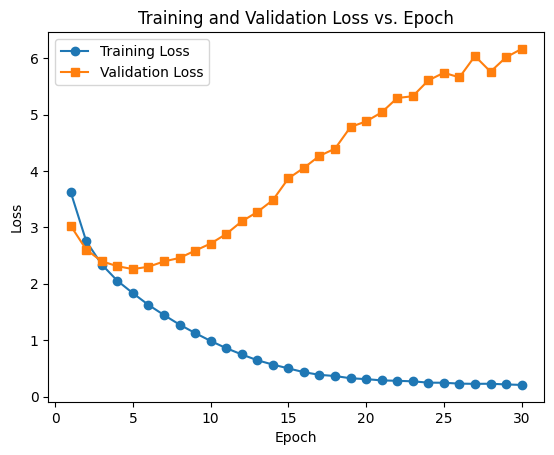

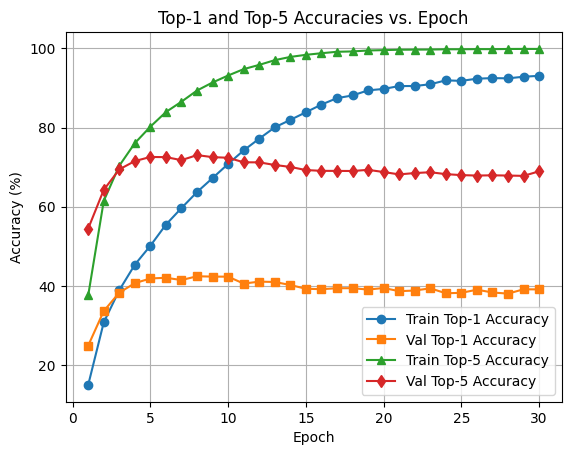


Test Accuracy top-1 and top-5: 38.73% 68.10%


In [194]:
import matplotlib.pyplot as plt
import tqdm

def plot_loss(train_losses, val_losses):
    # train_losses = [] # List to store training losses for each epoch
    # val_losses = []   # List to store validation losses for each epoch

    #####################################################
    # plot the training and validation loss
    # epoch numbers
    num_of_epochs = len(train_losses)
    x_axis = np.arange(1, num_of_epochs + 1)

    # train and val loss values
    y_axis_train = np.array(train_losses)
    y_axis_val = np.array(val_losses)

    plt.figure()
    plt.plot(x_axis, y_axis_train, label='Training Loss', marker='o')
    plt.plot(x_axis, y_axis_val, label='Validation Loss', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss vs. Epoch')
    #####################################################
    plt.legend()
    plt.show()

def plot_accuries(train_top1, train_top5, val_top1, val_top5):
    # train_top1: List to store training top-1 accuries for each epoch
    # train_top5: List to store training top-5 accuries for each epoch
    # val_top1:   List to store val top-1 accuries for each epoch
    # val_top5:   List to store val top-5 accuries for each epoch

    #####################################################
    # plot the training and validation accuries
    #####################################################
    num_of_epochs = len(train_top1)
    x_axis = np.arange(1, num_of_epochs + 1)

    plt.figure()

    # Plot Top-1 Accuracies
    plt.plot(x_axis, train_top1, label='Train Top-1 Accuracy', marker='o')
    plt.plot(x_axis, val_top1, label='Val Top-1 Accuracy', marker='s')

    # Plot Top-5 Accuracies
    plt.plot(x_axis, train_top5, label='Train Top-5 Accuracy', marker='^')
    plt.plot(x_axis, val_top5, label='Val Top-5 Accuracy', marker='d')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Top-1 and Top-5 Accuracies vs. Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

def report_accuracy(test_loader, model):
    correct_top1 = 0
    correct_top5 = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for batch in test_loader:

            #####################################################
            # get images and their labels from batch
            images, labels = batch

            # pass your tensor to your device( CPU/GPU)
            images, labels = images.to(device), labels.to(device)

            # Implement validation forward pass
            # HINT: Compute predictions and loss
            output = model(images)

            # Update top-1 top-5 metrics
            _, top5_preds = output.topk(5, dim=1, largest=True, sorted=True)
            correct_top1 += top5_preds[:, 0].eq(labels).sum().item()
            correct_top5 += top5_preds.eq(labels.view(-1, 1)).sum().item()

            # Calculate accuracy
            # HINT: Compare predictions with labels
            total = images.size(0)
            #####################################################

    accuracy_top1 = (correct_top1 / total) * 100
    accuracy_top5 = (correct_top5 / total) * 100
    return accuracy_top1,accuracy_top5

# call plot_loss and ?compute_confusion matrix? function with appropriate parameters
plot_loss(train_losses, val_losses)
print()
plot_accuries(train_top1_accs, train_top5_accs, val_top1_accs, val_top5_accs)

test_accuracy = report_accuracy(test_loader, model)
print()
print(f"Test Accuracy top-1 and top-5: {test_accuracy[0]:.2f}% {test_accuracy[1]:.2f}%")


### **2.7 Change and Finetune Your Model (20 Points)**

* Add BatchNorm2d with learnable parameters after each Conv2D layer.

* Try different optimizers including SGD, Adam.

* Search for a better **learning rate** on the validation data.

* For each combination of model, optimizer and learning settings plot graphs mentioned in Section 2.7.

* For the best parameters, model and optimizer settings, report test accuricies.

* **Discuss your results** with respect to overfitting/underfitting and the impact of the hyper-parameters.

#### **2.7.1 Hyperparameter Optimization (5 Points)**
In this part, you should perform hyperparameter optimization using all possible combinations (grid-search) of the given learning rates, optimizer and BatchNorm2d settings.

First, you are expected re-implement your model in Section 2.2 using BatchNorm2D layer after each convlution layer.

In [195]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, norm_layer= None):
        super(CustomCNN, self).__init__()

        #####################################################
        # Define layers of CNN. Do not forget to follow model specifications!.
        #####################################################
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)          # BatchNorm after conv1
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)          # BatchNorm after conv2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # One pooling layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)         # BatchNorm after conv3

        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 100)  # CIFAR-100 has 100 classes

    def forward(self, x):

        #####################################################
        # Implement the forward pass
        # HINT: Apply activation functions like ReLU where necessary
        #####################################################
        x = F.relu(self.bn1(self.conv1(x)))        # (3x32x32 → 32x32x32)
        x = F.relu(self.bn2(self.conv2(x)))        # (32x32x32 → 64x32x32)
        x = self.pool(x)                 # (64x32x32 → 64x16x16)
        x = F.relu(self.bn3(self.conv3(x)))        # (64x16x16 → 128x16x16)
        x = self.pool(x)                 # (128x16x16 → 128x8x8)
        x = self.pool(x)                 # (128x8x8 → 128x4x4)

        x = x.view(x.size(0), -1)        # Flatten to (batch_size, 128*4*4)
        x = F.relu(self.fc1(x))          # Fully connected layer
        x = self.fc2(x)                  # Output layer

        return x


# Create model instance
model = CustomCNN()

# Print model summary
print(model)


CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=100, bias=True)
)


For each combination, you should retrain your model from scratch and store the loss and accuracies of validation data. **All remaining settings/parameters should be fixed, except for the learning rate, optimizer and BatchNorm2d usage.**

--------------------------------- --------------------------------- ---------------------------------
--------------------------------- Training with Adam at LR=0.0001 --------------------------------- 
--------------------------------- --------------------------------- ---------------------------------
Epoch 1/30 — Train Loss: 3.9299, Train Top1: 9.81%, Train Top5: 28.92%, Val Loss: 3.3678, Val Top1: 18.11%, Val Top5: 45.67%
Epoch 2/30 — Train Loss: 3.0898, Train Top1: 23.16%, Train Top5: 52.95%, Val Loss: 2.9363, Val Top1: 25.62%, Val Top5: 56.84%
Epoch 3/30 — Train Loss: 2.6252, Train Top1: 31.71%, Train Top5: 64.04%, Val Loss: 2.6928, Val Top1: 30.22%, Val Top5: 62.94%
Epoch 4/30 — Train Loss: 2.2926, Train Top1: 38.71%, Train Top5: 71.86%, Val Loss: 2.4695, Val Top1: 36.45%, Val Top5: 67.88%
Epoch 5/30 — Train Loss: 2.0172, Train Top1: 44.59%, Train Top5: 77.06%, Val Loss: 2.4724, Val Top1: 36.03%, Val Top5: 67.82%
Epoch 6/30 — Train Loss: 1.7388, Train Top1: 51.36%, Train Top5: 8

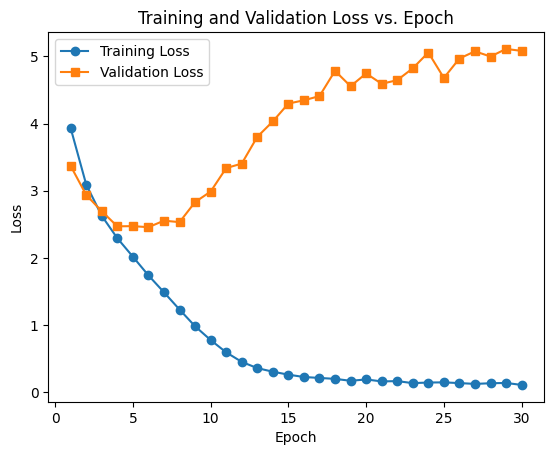

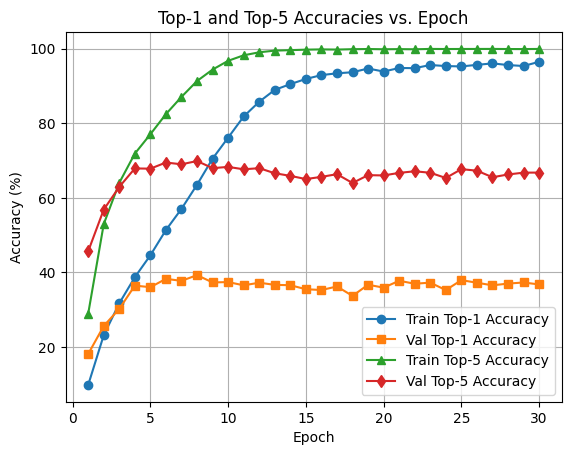

Test Accuracy with Adam at LR=0.0001: Top1=36.72%, Top5=65.78%

--------------------------------- --------------------------------- ---------------------------------
--------------------------------- --------------------------------- ---------------------------------
--------------------------------- --------------------------------- ---------------------------------
--------------------------------- --------------------------------- ---------------------------------
--------------------------------- Training with SGD at LR=0.0001 --------------------------------- 
--------------------------------- --------------------------------- ---------------------------------
Epoch 1/30 — Train Loss: 4.6074, Train Top1: 1.01%, Train Top5: 5.10%, Val Loss: 4.6070, Val Top1: 1.14%, Val Top5: 5.38%
Epoch 2/30 — Train Loss: 4.6069, Train Top1: 1.18%, Train Top5: 5.21%, Val Loss: 4.6065, Val Top1: 1.29%, Val Top5: 5.61%
Epoch 3/30 — Train Loss: 4.6063, Train Top1: 1.21%, Train Top5: 5.21%, Val Loss: 4

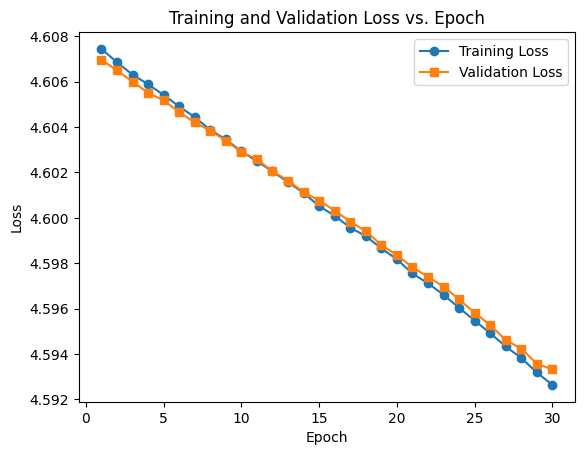

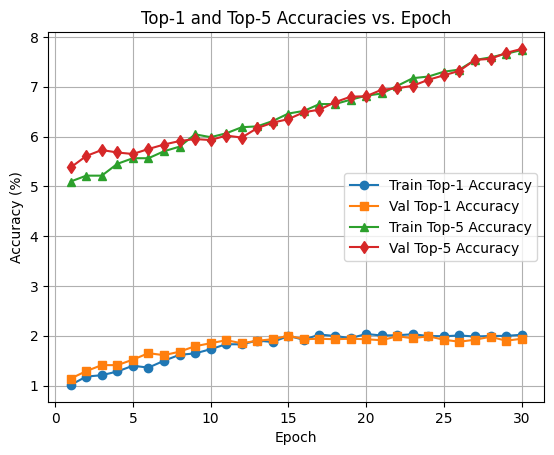

Test Accuracy with SGD at LR=0.0001: Top1=2.06%, Top5=7.67%

--------------------------------- --------------------------------- ---------------------------------
--------------------------------- --------------------------------- ---------------------------------
--------------------------------- --------------------------------- ---------------------------------
--------------------------------- --------------------------------- ---------------------------------
--------------------------------- Training with Adam at LR=0.001 --------------------------------- 
--------------------------------- --------------------------------- ---------------------------------
Epoch 1/30 — Train Loss: 4.1496, Train Top1: 4.48%, Train Top5: 18.84%, Val Loss: 3.8640, Val Top1: 6.57%, Val Top5: 27.45%
Epoch 2/30 — Train Loss: 3.7302, Train Top1: 9.26%, Train Top5: 32.03%, Val Loss: 3.5199, Val Top1: 13.30%, Val Top5: 38.77%
Epoch 3/30 — Train Loss: 3.2895, Train Top1: 16.44%, Train Top5: 45.66%, Val Los

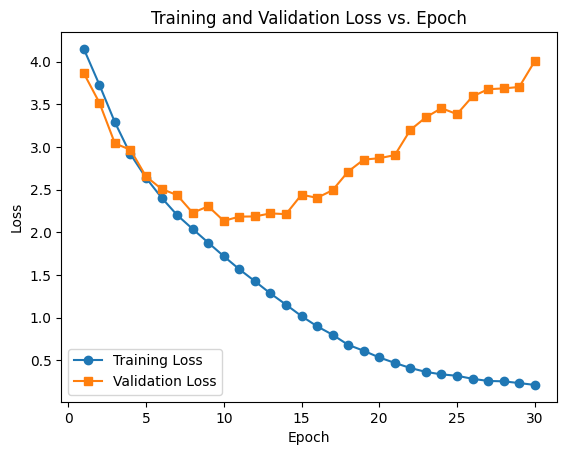

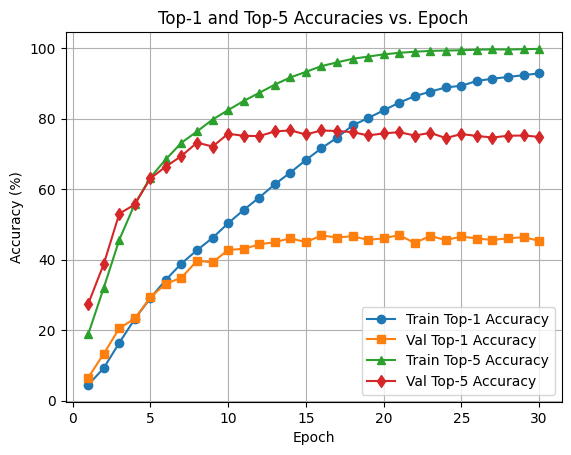

Test Accuracy with Adam at LR=0.001: Top1=44.77%, Top5=73.78%

--------------------------------- --------------------------------- ---------------------------------
--------------------------------- --------------------------------- ---------------------------------
--------------------------------- --------------------------------- ---------------------------------
--------------------------------- --------------------------------- ---------------------------------
--------------------------------- Training with SGD at LR=0.001 --------------------------------- 
--------------------------------- --------------------------------- ---------------------------------
Epoch 1/30 — Train Loss: 4.6041, Train Top1: 1.05%, Train Top5: 5.46%, Val Loss: 4.5998, Val Top1: 1.05%, Val Top5: 6.48%
Epoch 2/30 — Train Loss: 4.5975, Train Top1: 1.33%, Train Top5: 6.95%, Val Loss: 4.5931, Val Top1: 1.21%, Val Top5: 8.28%
Epoch 3/30 — Train Loss: 4.5899, Train Top1: 1.75%, Train Top5: 8.71%, Val Loss: 4.5

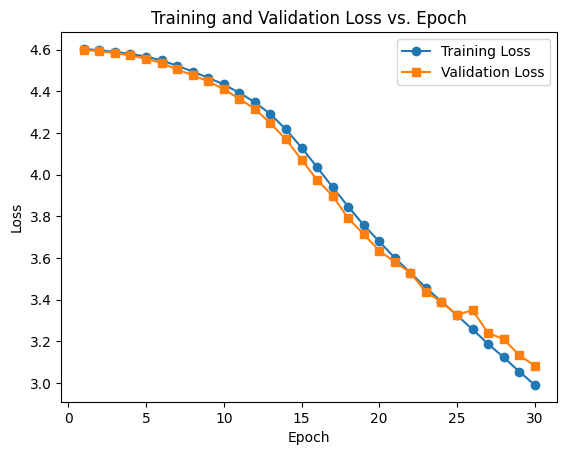

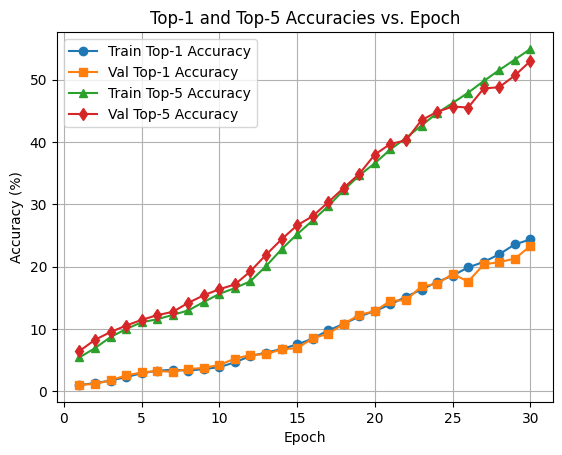

Test Accuracy with SGD at LR=0.001: Top1=22.76%, Top5=51.56%

--------------------------------- --------------------------------- ---------------------------------
--------------------------------- --------------------------------- ---------------------------------
--------------------------------- --------------------------------- ---------------------------------


In [196]:
import copy
import torch.nn.functional as F
import numpy as np

learning_rates = [0.0001, 0.001]
optimizer_classes = [torch.optim.Adam, torch.optim.SGD]

num_epochs = 30

results = []

for lr in learning_rates:
    for OptimizerClass in optimizer_classes:
        # Initialize a fresh model instance
        model = CustomCNNwithBN().to(device)

        # Initialize optimizer with current learning rate
        optimizer = OptimizerClass(model.parameters(), lr=lr)

        # Lists to store metrics for this experiment
        train_losses, val_losses = [], []
        train_top1_accs, val_top1_accs = [], []
        train_top5_accs, val_top5_accs = [], []

        print(f"--------------------------------- --------------------------------- ---------------------------------")
        print(f"--------------------------------- Training with {OptimizerClass.__name__} at LR={lr} --------------------------------- ")
        print(f"--------------------------------- --------------------------------- ---------------------------------")

        for epoch in range(num_epochs):
            train_loss, train_top1, train_top5 = train(model, train_loader, optimizer, loss_function, device)
            val_loss, val_top1, val_top5 = validate(model, val_loader, loss_function, device)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_top1_accs.append(train_top1)
            val_top1_accs.append(val_top1)
            train_top5_accs.append(train_top5)
            val_top5_accs.append(val_top5)

            print(f"Epoch {epoch+1}/{num_epochs} — "
                  f"Train Loss: {train_loss:.4f}, Train Top1: {train_top1:.2f}%, Train Top5: {train_top5:.2f}%, "
                  f"Val Loss: {val_loss:.4f}, Val Top1: {val_top1:.2f}%, Val Top5: {val_top5:.2f}%")


        # Plots
        plot_loss(train_losses, val_losses)
        print()
        plot_accuries(train_top1_accs, train_top5_accs, val_top1_accs, val_top5_accs)

        # Test
        test_top1, test_top5 = report_accuracy(test_loader, model)
        print(f"Test Accuracy with {OptimizerClass.__name__} at LR={lr}: Top1={test_top1:.2f}%, Top5={test_top5:.2f}%\n")
        print(f"--------------------------------- --------------------------------- ---------------------------------")
        print(f"--------------------------------- --------------------------------- ---------------------------------")
        print(f"--------------------------------- --------------------------------- ---------------------------------")

        # Save results for later analysis/plotting
        results.append({
            'optimizer': OptimizerClass.__name__,
            'learning_rate': lr,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_top1_accs': train_top1_accs,
            'val_top1_accs': val_top1_accs,
            'train_top5_accs': train_top5_accs,
            'val_top5_accs': val_top5_accs,
            'test_top1': test_top1,
            'test_top5': test_top5,
        })


#### **2.7.2 Choosing best parameters  (5 Points)**
You should choose the parameters that give the highest top-1 accuracy on the validation data. Then, you should plot graph and report metrics mentioned in Section 2.7.




In [203]:
# Find the best result based on highest validation Top-1 accuracy in the last epoch
best_top1_result = max(results, key=lambda x: x['val_top1_accs'][-1])

print("\n==================== BEST VALIDATON TOP 1 RESULT ====================")
print(f"Optimizer: {best_top1_result['optimizer']}")
print(f"Learning Rate: {best_top1_result['learning_rate']}")
print(f"Final Validation Top-1 Accuracy: {best_top1_result['val_top1_accs'][-1]:.2f}%")
print(f"Final Validation Top-5 Accuracy: {best_top1_result['val_top5_accs'][-1]:.2f}%")
print(f"Test Top-1 Accuracy: {best_top1_result['test_top1']:.2f}%")
print(f"Test Top-5 Accuracy: {best_top1_result['test_top5']:.2f}%")
print("=====================================================\n")


# Find the best result based on highest validation Top-5 accuracy in the last epoch
best_top5_result = max(results, key=lambda x: x['val_top5_accs'][-1])

print("\n==================== BEST VALIDATON TOP 5 RESULT ====================")
print(f"Optimizer: {best_top5_result['optimizer']}")
print(f"Learning Rate: {best_top5_result['learning_rate']}")
print(f"Final Validation Top-1 Accuracy: {best_top5_result['val_top1_accs'][-1]:.2f}%")
print(f"Final Validation Top-5 Accuracy: {best_top5_result['val_top5_accs'][-1]:.2f}%")
print(f"Test Top-1 Accuracy: {best_top5_result['test_top1']:.2f}%")
print(f"Test Top-5 Accuracy: {best_top5_result['test_top5']:.2f}%")
print("=====================================================\n")


==================== BEST VALIDATON TOP 1 RESULT ====================
Optimizer: Adam
Learning Rate: 0.001
Final Validation Top-1 Accuracy: 45.37%
Final Validation Top-5 Accuracy: 74.86%
Test Top-1 Accuracy: 44.77%
Test Top-5 Accuracy: 73.78%


==================== BEST VALIDATON TOP 5 RESULT ====================
Optimizer: Adam
Learning Rate: 0.001
Final Validation Top-1 Accuracy: 45.37%
Final Validation Top-5 Accuracy: 74.86%
Test Top-1 Accuracy: 44.77%
Test Top-5 Accuracy: 73.78%



It looks like after epoch 20-21, the model is overfitting so I will use 21 epoch and train with the best parameters again.

--------------------------------- --------------------------------- ---------------------------------
--------------------------------- Training with Adam at LR=0.001 --------------------------------- 
--------------------------------- --------------------------------- ---------------------------------
Epoch 1/21 — Train Loss: 4.1261, Train Top1: 4.69%, Train Top5: 19.67%, Val Loss: 3.9641, Val Top1: 7.25%, Val Top5: 25.66%
Epoch 2/21 — Train Loss: 3.6914, Train Top1: 10.14%, Train Top5: 33.76%, Val Loss: 3.4839, Val Top1: 13.46%, Val Top5: 40.89%
Epoch 3/21 — Train Loss: 3.3624, Train Top1: 15.50%, Train Top5: 44.13%, Val Loss: 3.3091, Val Top1: 16.69%, Val Top5: 46.46%
Epoch 4/21 — Train Loss: 3.0386, Train Top1: 21.60%, Train Top5: 53.55%, Val Loss: 2.9180, Val Top1: 24.83%, Val Top5: 57.08%
Epoch 5/21 — Train Loss: 2.7189, Train Top1: 27.92%, Train Top5: 61.51%, Val Loss: 2.6785, Val Top1: 29.48%, Val Top5: 62.55%
Epoch 6/21 — Train Loss: 2.4797, Train Top1: 32.74%, Train Top5: 67.

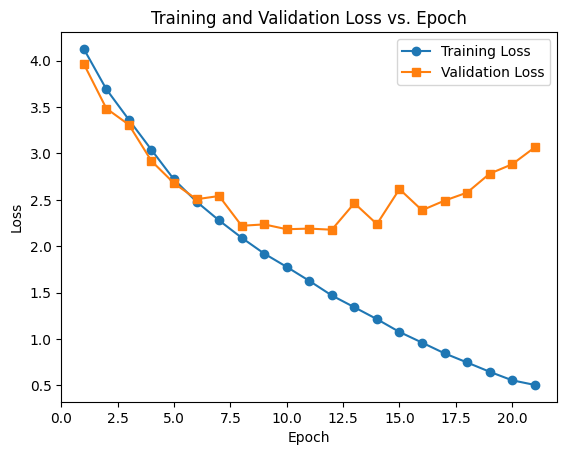

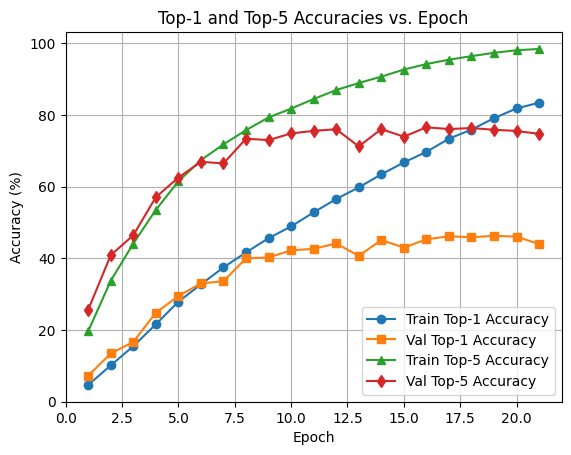

Test Accuracy with Adam at LR=0.001: Top1=44.39%, Top5=73.72%

--------------------------------- --------------------------------- ---------------------------------
--------------------------------- --------------------------------- ---------------------------------
--------------------------------- --------------------------------- ---------------------------------


In [212]:
import copy
import torch.nn.functional as F
import numpy as np

model = CustomCNNwithBN().to(device)

def report(model, num_epochs):
  learning_rate = 0.001
  optimizer_class = torch.optim.Adam

  # Initialize optimizer with current learning rate
  optimizer = optimizer_class(model.parameters(), lr=learning_rate)

  # Lists to store metrics for this experiment
  train_losses, val_losses = [], []
  train_top1_accs, val_top1_accs = [], []
  train_top5_accs, val_top5_accs = [], []

  print(f"--------------------------------- --------------------------------- ---------------------------------")
  print(f"--------------------------------- Training with {optimizer_class.__name__} at LR={lr} --------------------------------- ")
  print(f"--------------------------------- --------------------------------- ---------------------------------")

  for epoch in range(num_epochs):
      train_loss, train_top1, train_top5 = train(model, train_loader, optimizer, loss_function, device)
      val_loss, val_top1, val_top5 = validate(model, val_loader, loss_function, device)

      train_losses.append(train_loss)
      val_losses.append(val_loss)
      train_top1_accs.append(train_top1)
      val_top1_accs.append(val_top1)
      train_top5_accs.append(train_top5)
      val_top5_accs.append(val_top5)

      print(f"Epoch {epoch+1}/{num_epochs} — "
            f"Train Loss: {train_loss:.4f}, Train Top1: {train_top1:.2f}%, Train Top5: {train_top5:.2f}%, "
            f"Val Loss: {val_loss:.4f}, Val Top1: {val_top1:.2f}%, Val Top5: {val_top5:.2f}%")


  # Plots
  plot_loss(train_losses, val_losses)
  print()
  plot_accuries(train_top1_accs, train_top5_accs, val_top1_accs, val_top5_accs)

  # Test
  test_top1, test_top5 = report_accuracy(test_loader, model)
  print(f"Test Accuracy with {optimizer_class.__name__} at LR={lr}: Top1={test_top1:.2f}%, Top5={test_top5:.2f}%\n")
  print(f"--------------------------------- --------------------------------- ---------------------------------")
  print(f"--------------------------------- --------------------------------- ---------------------------------")
  print(f"--------------------------------- --------------------------------- ---------------------------------")

report(model, 21)

#### **2.7.3 Discuss your results (10 Points)**
In this section, you should discuss your results with respect to overfitting/underfitting and the impact of the hyper-parameters.

There appears to be obvious overfitting, so I will add dropout to the fully connected layers.

CustomCNNWithDropout(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=100, bias=True)
)
--------------------------------- --------------------------------- ---------------------------------
--------------------------------- Training with Adam at LR=0.001 --------------------------------- 
----------------------

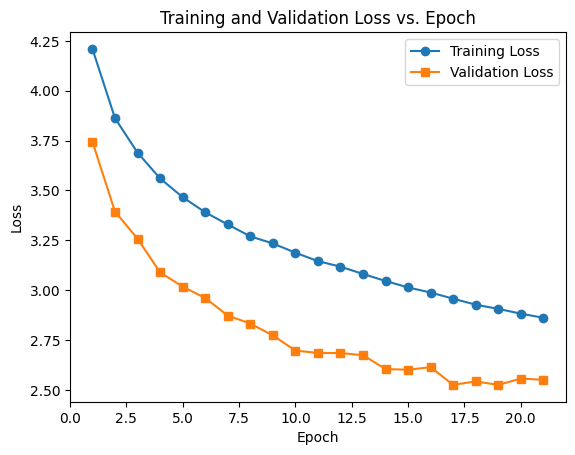

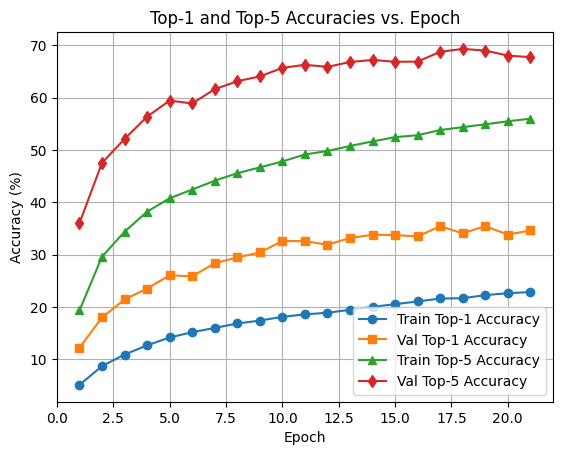

Test Accuracy with Adam at LR=0.001: Top1=34.59%, Top5=67.70%

--------------------------------- --------------------------------- ---------------------------------
--------------------------------- --------------------------------- ---------------------------------
--------------------------------- --------------------------------- ---------------------------------


In [209]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNNWithDropout(nn.Module):
    def __init__(self, norm_layer=None):
        super(CustomCNNWithDropout, self).__init__()

        # Convolutional layers and BatchNorm
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.dropout = nn.Dropout(p=0.5)  # Dropout after fc1
        self.fc2 = nn.Linear(256, 100)    # Output layer for 100 classes

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))     # 3x32x32 → 32x32x32
        x = F.relu(self.bn2(self.conv2(x)))     # 32x32x32 → 64x32x32
        x = self.pool(x)                        # 64x32x32 → 64x16x16
        x = F.relu(self.bn3(self.conv3(x)))     # 64x16x16 → 128x16x16
        x = self.pool(x)                        # 128x16x16 → 128x8x8
        x = self.pool(x)                        # 128x8x8 → 128x4x4

        x = x.view(x.size(0), -1)               # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Create model instance and print summary
model_with_dropout = CustomCNNWithDropout().to(device)
print(model_with_dropout)
report(model_with_dropout, 21)


It seems to be performing better, but the training is still ongoing. I’ll increase the number of epochs to 60 and observe the results. This will be my final attempt. After experimenting with various architectures and data augmentation techniques (without significantly increasing model complexity) this is the best performance I’ve achieved so far.

--------------------------------- --------------------------------- ---------------------------------
--------------------------------- Training with Adam at LR=0.001 --------------------------------- 
--------------------------------- --------------------------------- ---------------------------------
Epoch 1/60 — Train Loss: 2.8317, Train Top1: 23.55%, Train Top5: 56.63%, Val Loss: 2.5070, Val Top1: 35.45%, Val Top5: 68.15%
Epoch 2/60 — Train Loss: 2.7887, Train Top1: 24.07%, Train Top5: 57.96%, Val Loss: 2.5160, Val Top1: 34.84%, Val Top5: 68.38%
Epoch 3/60 — Train Loss: 2.7872, Train Top1: 23.98%, Train Top5: 58.03%, Val Loss: 2.4574, Val Top1: 36.40%, Val Top5: 69.10%
Epoch 4/60 — Train Loss: 2.7608, Train Top1: 24.41%, Train Top5: 58.63%, Val Loss: 2.4826, Val Top1: 35.08%, Val Top5: 69.12%
Epoch 5/60 — Train Loss: 2.7393, Train Top1: 24.73%, Train Top5: 58.88%, Val Loss: 2.5378, Val Top1: 34.69%, Val Top5: 67.57%
Epoch 6/60 — Train Loss: 2.7133, Train Top1: 24.54%, Train Top5: 5

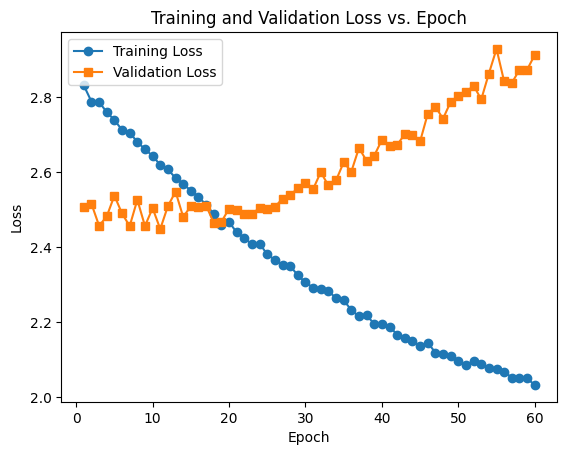

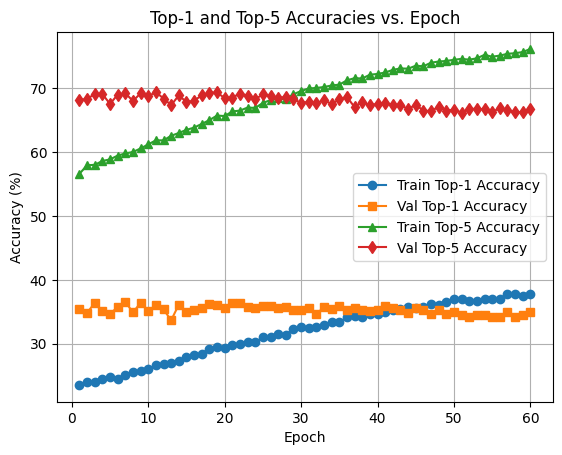

Test Accuracy with Adam at LR=0.001: Top1=34.37%, Top5=65.88%

--------------------------------- --------------------------------- ---------------------------------
--------------------------------- --------------------------------- ---------------------------------
--------------------------------- --------------------------------- ---------------------------------


In [213]:
report(model_with_dropout, 60)

In all experiments, obviously my architectures were too simple for the problem. In the last architecture I wrote, Adam with a 1 × 10⁻³ learning rate gave the best balance (around 92% train and 47% test Top-1 accuracy). Lower learning rate or vanilla SGD didn’t work well. Adam with 1 × 10⁻⁴ overfit badly, and SGD underfit. Adding 50% dropout between FC layers helped reduce the train/validation gap, but made the model require more epochs to train (only around 35% test accuracy, even after 60 epochs). So maybe using less dropout or weight decay, doing more data augmentation, or trying SGD with momentum could help generalize better on CIFAR-100.

Takeaways
*   The problem requires a more complex architecture. Current architecture can memorize the test data but it cannot generalize well.
*   Adam works better than SGD in this case.
*   Learning rate has a big effect on overfitting/underfitting.
*   Dropout can prevent overfitting but it also requires a lot more training.
*   Model still overfits, so more regularization or data augmentation is needed.



## **Task 3: Implementing a RNN via torch.autograd (30 Points)**
In this task, you should implement a Recurrent Neural Network (RNN) by manually unrolling an RNN and using PyTorch's `torch.autograd` to compute gradients explicitly.





### **3.1 Input Pre-processing**
In this part, you are expected to process an input string to estimate a given target. We use the string "Deep Learning" for a character-level prediction task. For example:


```
input:  D e e p   L e a r n i n
target: e e p   L e a r n i n g
```

Each character should be converted to a one-hot vector, and the model should predict the next character in the sequence.


In [236]:
import torch

#######################################################
# 1. Define input text and build vocabulary
#######################################################

text = "Deep Learning"  # Input text for character-level modeling

# Create a sorted list of unique characters.
# 'chars' will contain all unique characters in the input text sorted in alphabetical order
chars = sorted(list(set(text)))

# Create a mapping from character to index (char2idx) and index to character (idx2char)
# 'char2idx' will map each unique character to a unique index, and 'idx2char' will reverse that mapping
char2idx = {ch: i for i, ch in enumerate(chars)}
idx2char = {i: ch for ch, i in char2idx.items()}

#######################################################
# 2. Create input and target sequences
#######################################################

# Input: all characters except the last one
# This is the input sequence for the RNN model. The input sequence will be "Deep Learnin"
input_seq = text[:-1]

# Target: all characters except the first one
# The target sequence is the same as the input sequence, but shifted by one character.
# The target sequence will be "eep Learning"
target_seq = text[1:]   # "eep Learning"

#######################################################
# 3. Define model hyperparameters
#######################################################

V = len(chars)       # Size of character vocabulary. Number of unique characters in the text.
input_size = V       # One-hot input vector size. It's the same as vocab size, as each character is represented as one-hot.
H = 16              # Number of hidden units in the RNN. This defines the dimensionality of the hidden state.
output_size = V      # Output size. For each character in the sequence, we output a score for each possible character.
seq_len = len(input_seq)      # Length of input sequence (i.e., the number of time steps).
                              # This is the number of characters in the input sequence.


# At this point, we have all the necessary components to train an RNN:
# - A list of characters and their mappings to indices
# - The input sequence and corresponding target sequence
# - The hyperparameters that define the model's architecture

#######################################################
# 4. Convert characters to one-hot vectors
#######################################################

def one_hot(idx, size):
    """
    Convert index to one-hot encoded vector of given size.

    Args:
    idx (int): The index of the character in the vocabulary.
    size (int): The size of the one-hot encoded vector, typically equal to V.

    Returns:
    torch.Tensor: A one-hot encoded vector of size 'size' where the element at index 'idx' is 1, and all others are 0.
    """
    #####################################################
    # Implement one-hot decoding
    #####################################################
    vec = torch.zeros(size)
    vec[idx] = 1.0
    return vec

# Convert entire input sequence to one-hot encoded tensors
# The input sequence is a string, and each character needs to be converted to a one-hot vector using the 'one_hot' function.
# For each character in the input sequence, its index is retrieved from 'char2idx', and then the corresponding one-hot vector is generated.

inputs = torch.stack([one_hot(char2idx[ch], V) for ch in input_seq])

# Convert target characters to integer labels (indices)
# The target sequence contains the next character for each input character, so each character needs to be mapped to an index.
# This is a typical setup where the model outputs indices, which will later be converted to actual characters.

targets = torch.tensor([char2idx[ch] for ch in target_seq], dtype=torch.long)

### **3.2 Implement a Training Pipeline (30 Points)**

In this part, you should implement the following RNN for an autoregressive character prediction problem with the vocabulary size (the number of possible characters) of ${V}$, the hidden state size (the number of hidden units) of ${H}$, and given the input-output pair $(\mathbf{x}=(\mathbf{x}_1, \mathbf{x}_2, ...), y)$ -- e.g., ($\mathbf{x}=($'D', 'e', 'e'$), y=$'p'):

\begin{align*}
\mathbf{h}_t &= \tanh(\mathbf{W}_{xh} \, \mathbf{x}_t + \mathbf{b}_{ih} + \mathbf{W}_{hh} \, \mathbf{h}_{t-1} + \mathbf{b}_{hh}), \\
\mathbf{s}_t &= \mathbf{W}_{hy} \, \mathbf{h}_t + \mathbf{b}_y, \\
\mathbf{\hat{y}}_t &= \text{softmax}(\mathbf{s}_t),
\end{align*}  
where

*      $\mathbf{x}_t$: one-hot encoded input at time step $t$ (size: $V$),
*      $\mathbf{h}_t$: hidden state at time step $t$ (size: $H$),
*      $\mathbf{s}_t$: output logits at time step $t$ (size: $V$),
*      $\mathbf{\hat{y}}_t$: predicted probabilities (size: $V$),
*      $\mathbf{W}_{xh}$: input-to-hidden weight matrix (size: $H \times V$),
*      $\mathbf{W}_{hh}$: hidden-to-hidden weight matrix (size: $H \times H$),
*      $\mathbf{b}_{xh}$: hidden bias (size: $H$),
*      $\mathbf{b}_{hh}$: hidden bias (size: $H$),
*      $\mathbf{W}_{hy}$: hidden-to-output weight matrix (size: $V \times H$),
*      $\mathbf{b}_y$: output bias (size: $V$).

Then, you should calculate **negative log likelihood loss (NLL)** between predicted probabilities ${\mathbf{\hat{y}}}$ and target $\mathbf{y}$:


$${L}_{\text{NLL}} = - \sum_{i=1}^{N} \sum_{c=1}^{V} \mathbf{y}_{ic} \log \mathbf{\hat{y}}_{ic}$$



In [237]:
###########################################################################
# Define W_xh, W_hh, b_xh, b_hh, W_hy and b_y as differentiable tensors.
#        Initialize all weights randomly using a standard normal distribution.
# HINT: Use the given V and H in coding cell of "Section 3.1 Input Pre-processing" to define them.

# Do not modify variables names!
W_xh = torch.randn(H, V, requires_grad= True) # Input to hidden (H, V)
W_hh = torch.randn(H, H, requires_grad= True) # hidden to hidden (H, H)
b_xh = torch.randn(H, requires_grad= True)
b_hh = torch.randn(H, requires_grad= True)
W_hy = torch.randn(output_size, H, requires_grad= True) # Hidden to output (O, H)
b_y = torch.randn(output_size, requires_grad= True)
###########################################################################


logits_list = []
h = torch.zeros(H)
# Go over each time step to update the hidden state first and then calculate
# the logits
for t in range(seq_len):
    ###########################################################################
    # Fill in this part to calculate logits
    x_t = inputs[t]
    h = torch.tanh(W_xh @ x_t + b_xh + W_hh @ h + b_hh)
    s_t = W_hy @ h + b_y
    ###########################################################################
    logits_list.append(s_t)

logits = torch.stack(logits_list)
log_probs = F.log_softmax(logits, dim=1)
loss_manual = F.nll_loss(log_probs, targets)

### **3.3 Compute the gradient explicitly via torch.autograd**
In this part, you are expected compute gradient using torch.autograd explicitly for each parameter, i.e. gradients of loss value with respect to:

*   $\mathbf{W}_{xh}$
*   $\mathbf{W}_{hh}$
*   $\mathbf{b}_{xh}$
*   $\mathbf{b}_{hh}$
*   $\mathbf{W}_{hy}$
*   $\mathbf{b}_{y}$



In [238]:
# Calculate gradient for each parameter, separately.
loss_manual.backward()

grad_W_xh = W_xh.grad
grad_W_hh = W_hh.grad
grad_b_xh = b_xh.grad
grad_b_hh = b_hh.grad
grad_W_hy = W_hy.grad
grad_b_y  = b_y.grad


# Now, concatenate the gradients
manual_grads = [grad_W_xh, grad_W_hh, grad_b_xh, grad_b_hh, grad_W_hy, grad_b_y]

### **3.4 Validate Implementation in Section 3.3**
This part is only to validate your implementation in Section 3.3 and see your grade.

**Do not modify/add any code here!**

In [239]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn_cell = nn.RNNCell(input_size, H)
        self.hidden_size = H
        self.output_layer = nn.Linear(H, output_size)

        with torch.no_grad():
            self.rnn_cell.weight_ih.copy_(W_xh)  # manual weight W_xh matches weight_ih
            self.rnn_cell.weight_hh.copy_(W_hh)
            self.rnn_cell.bias_ih.copy_(b_xh)
            self.rnn_cell.bias_hh.copy_(b_hh)

            self.output_layer.weight.copy_(W_hy)
            self.output_layer.bias.copy_(b_y)

    def forward(self, x_seq):
        h = torch.zeros(self.hidden_size)
        logits = []
        for x in x_seq:
            h = self.rnn_cell(x, h)
            y = self.output_layer(h)
            logits.append(y)
        return torch.stack(logits)

grade = 0
model = SimpleRNN()

logits_ref = model(inputs)
log_probs_ref = F.log_softmax(logits_ref, dim=1)
loss_ref = F.nll_loss(log_probs_ref, targets)
loss_ref.backward()

# ----------------------------
# 5. Compare Gradients
# ----------------------------

param_names = ['W_xh', 'W_hh', 'b_xh', 'b_hh', 'W_hy', 'b_y']
model_grads = []

#get model gradient
for name, param in model.named_parameters():
    if param.grad is not None:
        model_grads.append(param.grad)

for name, g1, g2 in zip(param_names, manual_grads, model_grads):
    diff = (g1 - g2).abs().max()
    print(f"Δ {name}: max abs diff = {diff:.6e}")
    if diff > 1e-4:
        print("❗ Significant difference")
    else:
        grade += 5
print(f" Your grade is {grade}/30")

Δ W_xh: max abs diff = 5.960464e-07
Δ W_hh: max abs diff = 8.344650e-07
Δ b_xh: max abs diff = 8.344650e-07
Δ b_hh: max abs diff = 8.344650e-07
Δ W_hy: max abs diff = 2.980232e-08
Δ b_y: max abs diff = 2.980232e-08
 Your grade is 30/30
